In [2]:
import numpy as np 
import pandas as pd 
import sklearn
# библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# библиотеки для создания и обучения модели
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

# Импортируем библиотеки, необходимые для преобразования признаков
import category_encoders as ce
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import geopy

from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import geopy

In [3]:
hotels = pd.read_csv('data/hotels.csv')
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [4]:
# Подсчёт уникальных названий отелей
unique_hotels = hotels['hotel_name'].nunique()

print(f"Количество уникальных отелей: {unique_hotels}")

Количество уникальных отелей: 1492


In [5]:
# Преобразование столбца review_date в формат datetime
hotels['review_date'] = pd.to_datetime(hotels['review_date'])

# Поиск самого свежего и самого первого отзыва
most_recent_review = hotels['review_date'].max()
earliest_review = hotels['review_date'].min()

print("Самый свежий отзыв:", most_recent_review.strftime('%Y-%m-%d'))
print("Самый первый отзыв:", earliest_review.strftime('%Y-%m-%d'))

# Преобразование review_date обратно в строковый формат
hotels['review_date'] = hotels['review_date'].dt.strftime('%Y-%m-%d')

Самый свежий отзыв: 2017-08-03
Самый первый отзыв: 2015-08-04


In [10]:
# Обновленное регулярное выражение
regex = r'\'([a-zA-Z0-9- ]+)\''

# Извлечение тегов
hotels['tag_list'] = hotels['tags'].str.findall(regex)

# Создание множества для хранения уникальных тегов
tags_unique = set()
for i in hotels['tag_list']:
    tags_unique.update(i)  # Добавляем все теги из текущего списка

# Вывод количества уникальных тегов
print("Количество уникальных тегов:", len(tags_unique))


Количество уникальных тегов: 2368


In [7]:
# Разделение тегов и удаление лишних пробелов
all_tags = hotels['tags'].str.split(',').explode().str.strip()

# Подсчёт количества вхождений каждого тега
tag_counts = all_tags.value_counts()

# Тег с наибольшим числом вхождений
most_common_tag = tag_counts.idxmax()
most_common_tag_count = tag_counts.max()

print(f"Тег '{most_common_tag}' представлен в наибольшем числе отзывов: {most_common_tag_count} раз(а).")

Тег '[' Leisure trip '' представлен в наибольшем числе отзывов: 312768 раз(а).


In [8]:
# Извлечение информации о количестве ночей
def extract_nights(tag_string):
    matches = re.findall(r'Stayed (\d+) night', tag_string)  # Ищем фразы "Stayed X night(s)"
    return [int(match) for match in matches]  # Преобразуем найденные числа в int

# Применяем функцию ко всем строкам
hotels['nights'] = hotels['tags'].apply(lambda x: extract_nights(x))

# Собираем все ночи в один список
all_nights = hotels['nights'].explode()

# Подсчёт частоты
most_common_night_count = all_nights.value_counts().idxmax()
most_common_night_frequency = all_nights.value_counts().max()

print(f"Чаще всего путешественники останавливаются на {most_common_night_count} ночей. Это встречается {most_common_night_frequency} раз(а).")

NameError: name 're' is not defined

In [ ]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 19 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [ ]:
# Извлекаем только числовые значения из строк и преобразуем в int
hotels['days_since_review'] = hotels['days_since_review'].str.extract('(\d+)').astype(int)

# Проверка результата
print(hotels['days_since_review'].head())

0    531
1    203
2    289
3    681
4    516
Name: days_since_review, dtype: int32


In [ ]:
# Извлечение города с использованием функции
def get_city(arg):
    if arg.split()[-2] == 'United':
        return arg.split()[-5]
    else:
        return arg.split()[-2]
hotels['city'] = hotels['hotel_address'].apply(get_city)

# Применение бинарного кодирования (One-Hot-Encoding)
city_dummies = pd.get_dummies(hotels['city'], prefix='city')

# Объединение с оригинальным DataFrame
hotels = pd.concat([hotels, city_dummies], axis=1)

# Печать результата
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,lng,tag_list,nights,city,city_Amsterdam,city_Barcelona,city_London,city_Milan,city_Paris,city_Vienna
0,Stratton Street Mayfair Westminster Borough Lo...,581,2016-02-19,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,...,-0.143671,"[ Leisure trip , Couple , Studio Suite , St...",[2],London,False,False,True,False,False,False
1,130 134 Southampton Row Camden London WC1B 5AF...,299,2017-01-12,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,...,-0.123097,"[ Business trip , Couple , Standard Double R...",[1],London,False,False,True,False,False,False
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,2016-10-18,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,...,2.325643,"[ Leisure trip , Solo traveler , Modern Doub...",[3],Paris,False,False,False,False,True,False


In [ ]:
# # убираем признаки которые еще не успели обработать, 
# # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
hotels.drop(object_columns, axis = 1, inplace=True)

# # заполняем пропуски самым простым способом
hotels = hotels.fillna(0)

In [ ]:
print(hotels.columns)

Index(['additional_number_of_scoring', 'average_score',
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'reviewer_score',
       'days_since_review', 'lat', 'lng', 'city_Amsterdam', 'city_Barcelona',
       'city_London', 'city_Milan', 'city_Paris', 'city_Vienna'],
      dtype='object')


In [ ]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score'] 

In [ ]:
# Непрерывные признаки
num_cols = [
    'additional_number_of_scoring',
    'review_total_negative_word_counts',
    'total_number_of_reviews',
    'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given',
    'lat',
    'lng'
]

# Категориальные признаки
cat_cols = [
    'average_score', 
    'lat',   
]


<Axes: >

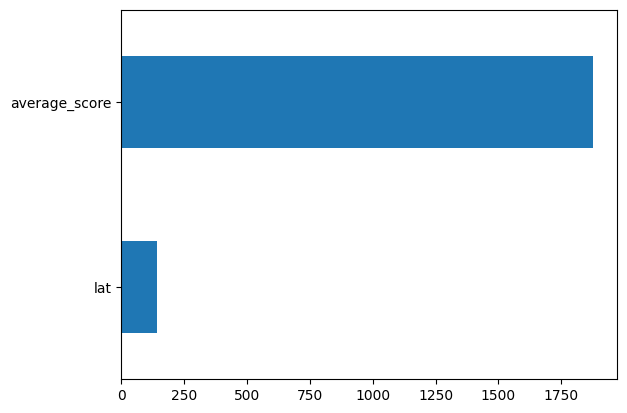

In [ ]:
y=y.astype('int')

...
from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<Axes: >

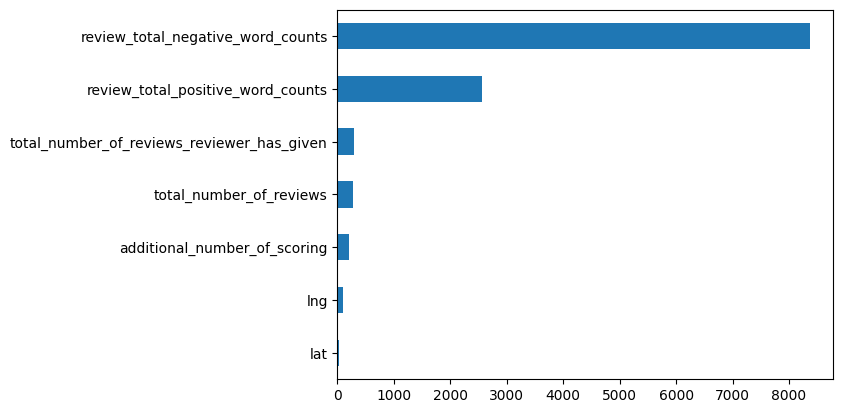

In [ ]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [ ]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [ ]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


In [ ]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.16346155359943784
